In [2]:
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pprint as pp
import numpy as np
import document_processor as dp
import test
from LOD_extraction import entities_distribution
from mongo_hc import MongoHC
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from IPython.display import Math
from alchemyapi_python.alchemyapi import AlchemyAPI

In [3]:
%matplotlib inline

In [4]:
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

In [28]:
def plot(df, x, y):
    k = x
    g = sns.barplot(x=x, y=y, data=df, palette=sns.color_palette("Reds", n_colors=df.shape[0]))
    g.set_xticklabels(df[k], rotation=90)
    sns.plt.show()

In [5]:
mongo_test = MongoHC('hc','test')

#### Esempio di richiesta Alchemy API

In [20]:
alchemyapi = AlchemyAPI()

In [25]:
text = """Credit cards offer many advantages. There is the convenience of being able to buy needed items now and
the security of not having to carry cash. You also receive fraud protection and in some cases rewards for making 
purchases. With these advantages also come responsibilities. You need to manage credit cards wisely by understanding
all of the card's terms and conditions; stay on top of payments; and realize the true cost of purchases made
with credit. Using a credit card is like taking out a loan. If you don't pay your card balance in full each month,
you'll pay interest on that loan. """

response = alchemyapi.entities('text', text, {'sentiment': 1})
pp.pprint(response)

{u'entities': [{u'count': u'1',
                u'relevance': u'0.875446',
                u'sentiment': {u'score': u'0.671268', u'type': u'positive'},
                u'text': u'fraud',
                u'type': u'Crime'}],
 u'language': u'english',
 u'status': u'OK',
 u'totalTransactions': u'2',
 u'url': u'',
 u'usage': u'By accessing AlchemyAPI or using information generated by AlchemyAPI, you are agreeing to be bound by the AlchemyAPI Terms of Use: http://www.alchemyapi.com/company/terms.html'}


## Approccio
Ho definito 2 matrici sparse, matrice *T* con i tfidf calcolati tramite `TfidfVectorizer` di `sklearn`, l'altra *E* con le entità estratte con le alchmemy API e la loro relativa rilevanza. Unendo le 2 matrici il risultato del clustering (*f_score*) è peggiorato notevolmente. Questo è dovuto all distribuzione dei dati all'interno delle 2 matrici. (grafico con le distribuzioni).

Perciò ho cercato il modo di dare un peso alle 2 matrici per bilanciare il risulato. Ho quindi definito un parametro *gamma*:

$$ 0 < \gamma < 1 $$

applicando poi la seguente formula:

$$ \gamma * T \lor (1 - \gamma) * E $$

In [4]:
?mongo_test.get_by_key

In [5]:
baseline = mongo_test.get_by_key('test', 'baseline')[0]
print 'f_score di partenza: %s' % baseline['avg_f_score']

f_score di partenza: 0.664877327235


In [8]:
# estraggo le entità con e la loro occorrenza nei documenti
d = entities_distribution('hc', 're0')
data  = [{'entity': k, 'count': v} for k,v in d[0].iteritems()]

In [9]:
ent_df = pd.DataFrame(data)
print "entita' trovate %s" % ent_df.shape[0]

entita' trovate 2480


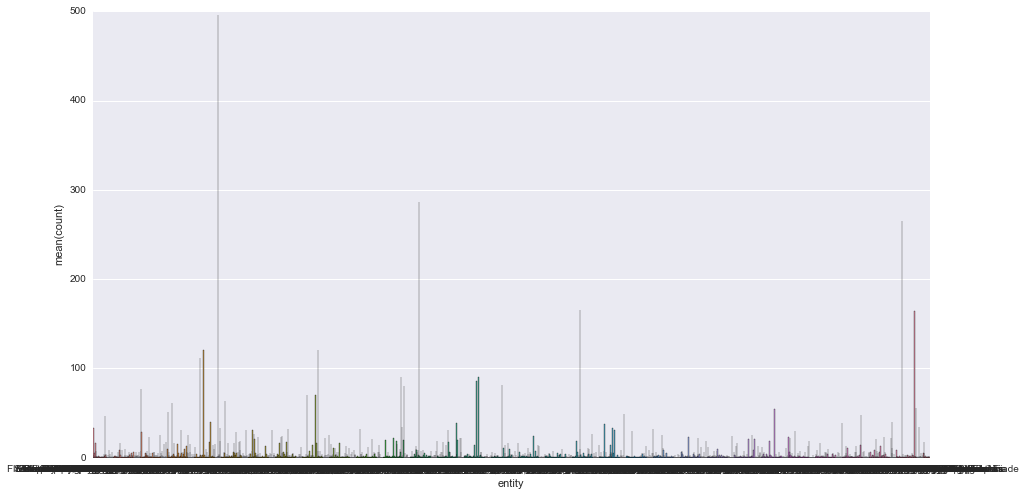

In [10]:
g = sns.barplot(x='entity', y='count', data=ent_df)

In [11]:
filter_ent_df = ent_df[(ent_df['count'] > 2) & (ent_df['count'] < 300)]
print "entita' trovate %s" % filter_ent_df.shape[0]

entita' trovate 542


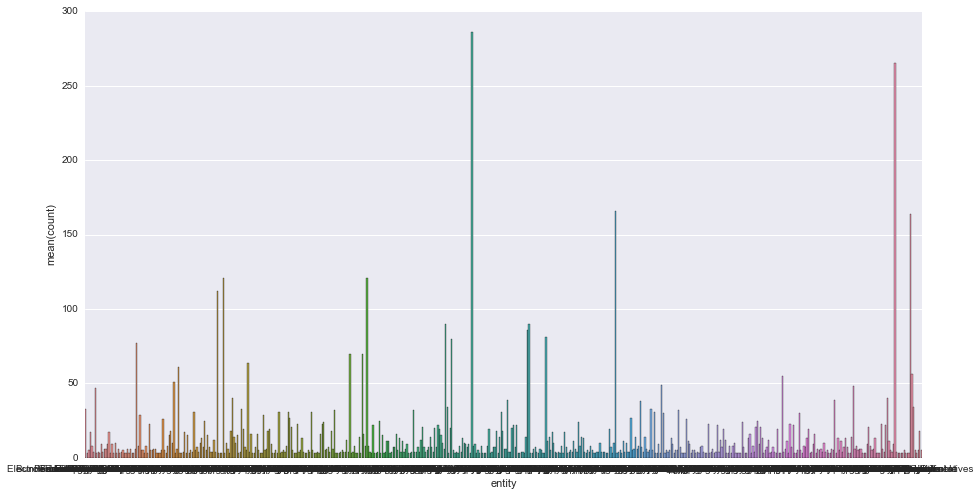

In [12]:
g = sns.barplot(x='entity', y='count', data=filter_ent_df)

In [14]:
print "media delle occorrenze: %s" % filter_ent_df['count'].mean()

media delle occorrenze: 12.3911439114


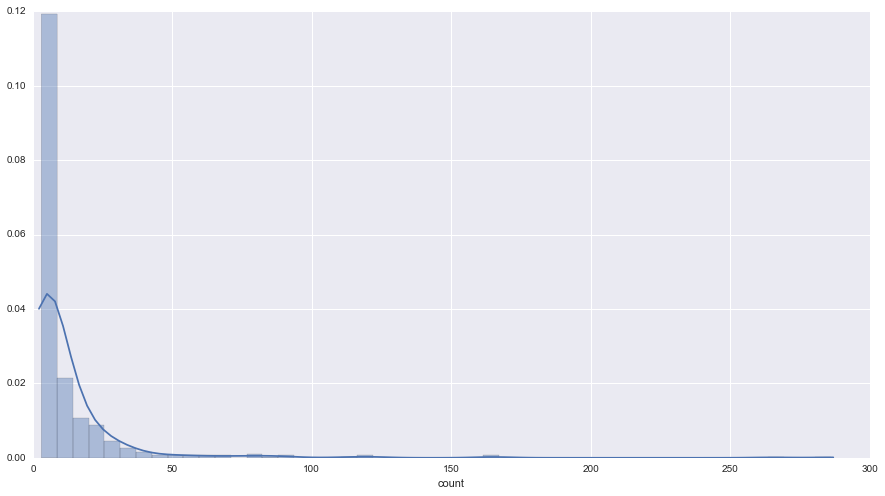

In [16]:
sns.distplot(filter_ent_df['count']);
sns.plt.show()

### Primo test
Le rilevanze delle entità non sono state filtrate, ho usato tutte quelle che avevo a disposizione.

In [21]:
data = [res for res in mongo_test.get_doc_with_no_key('test', order_by='n_attempt')]

In [22]:
test_1 = pd.DataFrame(data)

In [20]:
filt = test_1[test_1['gamma'] > 0.6]
filt.shape

(39, 30)

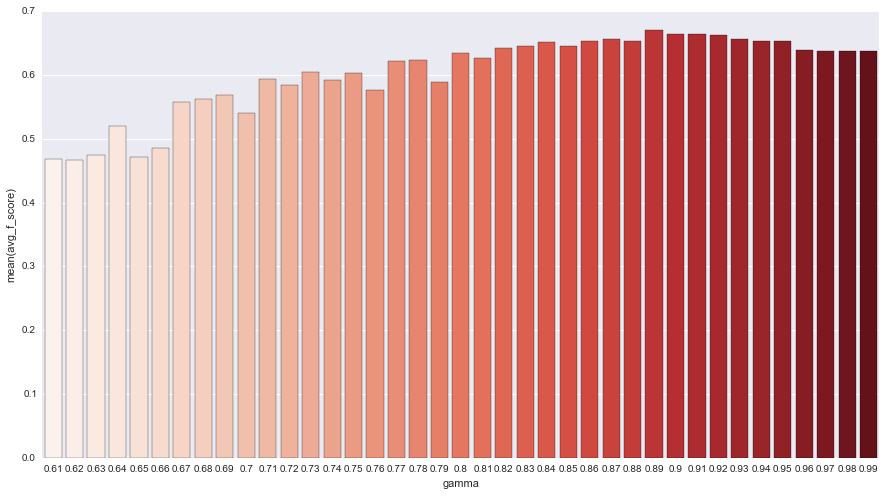

In [21]:
g = sns.barplot(x='gamma', y='avg_f_score', data= test_1[test_1['gamma'] > 0.6],
                palette=sns.color_palette("Reds", n_colors=filt.shape[0]))

In [22]:
test_1[test_1['avg_f_score'] == test_1['avg_f_score'].max()][['gamma', 'avg_f_score']]

,_id,alchemy_entities,all_fscore,analyzer,avg_f_score,avg_nnz_row,binary,classes,decode_error,encoding,...,preprocessor,relevance_threshold,smooth_idf,stop_words,strip_accents,sublinear_tf,token_pattern,tokenizer,use_idf,vocabulary
0,55f1415d2f49e54889b5c4fb,2480,"[0.166666666667, 0.380952380952, 0.10969196093...",word,0.361115,7.511886,False,13,strict,utf-8,...,None,0,True,english,unicode,False,(?u)\b\w\w+\b,TextUtils.tokenize_and_stem,True,None


### Secondo test
Ho usato solo le entità con una rilevanza maggiore di 0,7.

In [23]:
second_test =  [res for res in mongo_test.get_by_key(key='test', value='second', order_by='n_attempt')]

In [24]:
test_2 = pd.DataFrame(second_test)
test_2.shape


(90, 31)

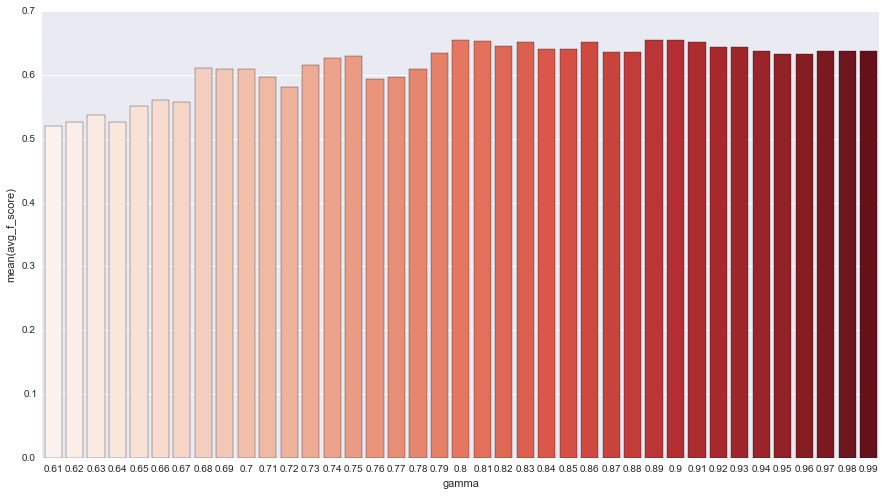

In [28]:
g = sns.barplot(x='gamma', y='avg_f_score', data= test_2[test_2['gamma'] > 0.6],
                palette=sns.color_palette("Reds", n_colors=filt.shape[0]))

In [29]:
test_2[test_2['avg_f_score'] == test_2['avg_f_score'].max()][['gamma', 'avg_f_score']]

,gamma,avg_f_score
79,0.89,0.655783


### Terzo test
Ho usato solo le entità con una rilevanza maggio di 0,8.

In [25]:
third_test =  [res for res in mongo_test.get_by_key(key='test', value='third', order_by='n_attempt')]

In [26]:
test_3 = pd.DataFrame(third_test)
test_3.shape

(90, 31)

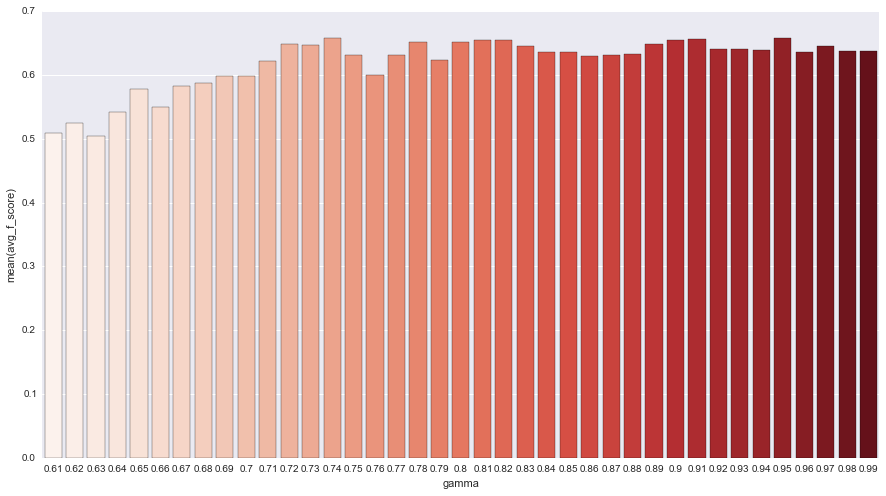

In [35]:
g = sns.barplot(x='gamma', y='avg_f_score', data= test_3[test_3['gamma'] > 0.6],
                palette=sns.color_palette("Reds", n_colors=filt.shape[0]))

In [36]:
test_3[test_3['avg_f_score'] == test_3['avg_f_score'].max()][['gamma', 'avg_f_score']]

,gamma,avg_f_score
85,0.95,0.658304


### Quarto test
Ho deciso di filtrare le entità anche in base alle loro occorrenze, prendendo solo quelle che appaiono in più di 2 documenti e in meno di 300, oltre che alla rilevanza maggiore di 0.8.

In [27]:
fourth_test =  [res for res in mongo_test.get_by_key(key='test', value='fourth', order_by='n_attempt')]

In [28]:
test_4 = pd.DataFrame(fourth_test)
test_4.shape

(90, 31)

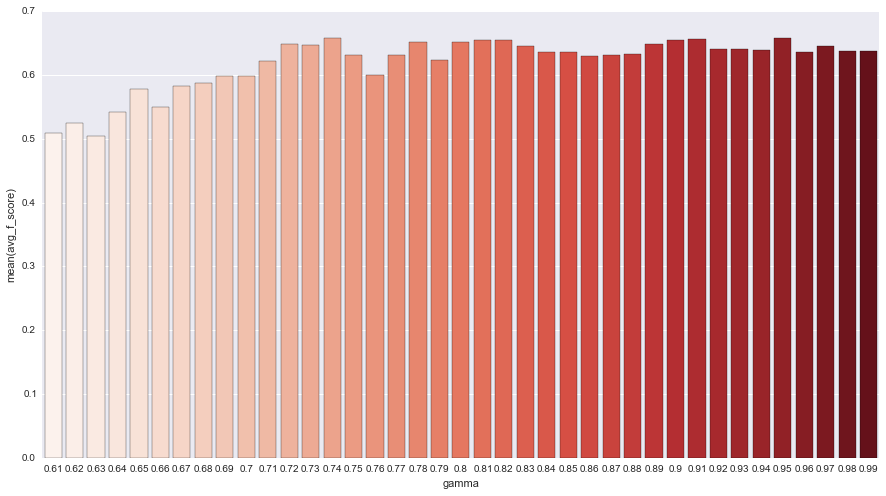

In [41]:
g = sns.barplot(x='gamma', y='avg_f_score', data= test_3[test_3['gamma'] > 0.6],
                palette=sns.color_palette("Reds", n_colors=filt.shape[0]))

In [42]:
test_4[test_4['avg_f_score'] == test_4['avg_f_score'].max()][['gamma', 'avg_f_score']]

,gamma,avg_f_score
80,0.9,0.659254


In [29]:
all_runs = pd.concat([test_1, test_2, test_3, test_4])
all_runs.shape

(360, 31)

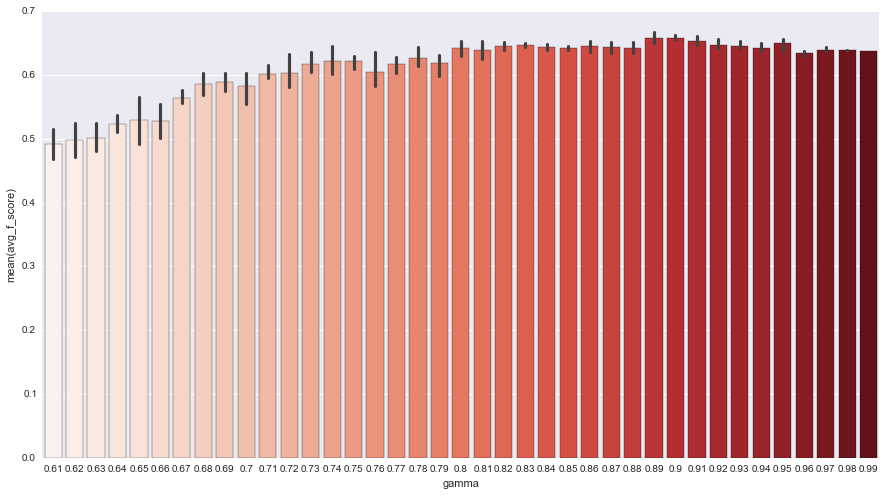

In [45]:
g = sns.barplot(x='gamma', y='avg_f_score', data= all_runs[all_runs['gamma'] > 0.6],
                palette=sns.color_palette("Reds", n_colors=filt.shape[0]))

In [61]:
best = all_runs[all_runs['avg_f_score'] == all_runs['avg_f_score'].max()][['test', 'gamma', 'avg_f_score']]
best['test'] = 'first'
best

,test,gamma,avg_f_score
79,first,0.89,0.671024


In [ ]:
g = sns.FacetGrid(all_runs, col="avg_f_score",  row="gamma")
g = g.map(plt.hist, "total_bill")

### Entità estratte con datatTXT

Servizio analogo a Alchemy API fatto ad *spaziodati* di Trento

https://dandelion.eu/semantic-text/entity-extraction-demo/

In [6]:
dandelion_first =  [res for res in mongo_test.get_by_key(key='test', value='first_dandelion', order_by='n_attempt')]
dandelion_first = pd.DataFrame(dandelion_first)
dandelion_first.shape

(90, 31)

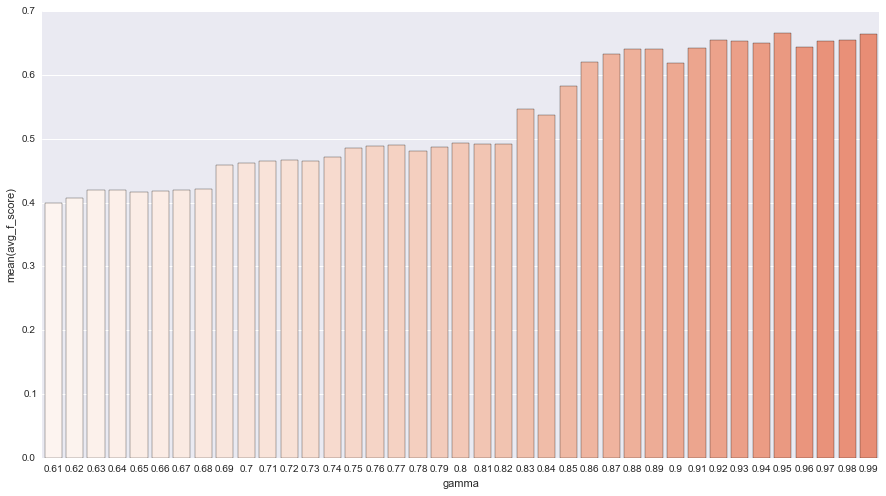

In [11]:
g = sns.barplot(x='gamma', y='avg_f_score', data= dandelion_first[dandelion_first['gamma'] > 0.6],
                palette=sns.color_palette("Reds", n_colors=dandelion_first.shape[0]))

In [8]:
best = dandelion_first[dandelion_first['avg_f_score'] == dandelion_first['avg_f_score'].max()][['test', 'gamma', 'avg_f_score']]
best

,test,gamma,avg_f_score
85,first_dandelion,0.95,0.66581


In [6]:
dandelion_second =  [res for res in mongo_test.get_by_key(key='test', value='second_dandelion', order_by='n_attempt')]
dandelion_second = pd.DataFrame(dandelion_second)
dandelion_second.shape

(90, 31)

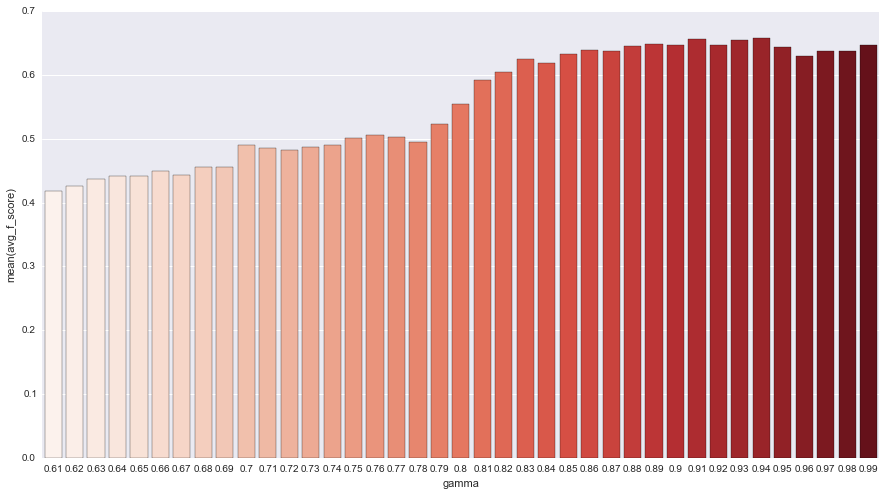

In [7]:
filt = dandelion_second[dandelion_second['gamma'] > 0.6]
g = sns.barplot(x='gamma', y='avg_f_score', data=filt,
                palette=sns.color_palette("Reds", n_colors=filt.shape[0]))

In [10]:
best = dandelion_second[dandelion_second['avg_f_score'] == dandelion_second['avg_f_score'].max()][['test', 'gamma', 'avg_f_score']]
best

,test,gamma,avg_f_score
84,second_dandelion,0.94,0.658652
